## 1.- Diccionario de atributos

anime_id - Identificador de anime de la pagina myanimelist.net's, es unico para cada anime.

name - Nombre Completo del anime.

genre - Genero del anime.

type - Serie, pelicula, Ova etc.

episodes - Cuantos Episodios tiene.

rating - Puntuación del anime.

members - Numero de miembros en su grupo de fans.

user_id - Codigo de identificación de usuario, se genera aleatoreamente. 

rating - Puntuación de 1 a 10. El valor -1 denota animes vistos por el usuario pero no puntuados.

## 2.- Importación de Librerias

In [1]:
import dask.dataframe as dd
from numba import jit
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import SlopeOne
from surprise import CoClustering
from surprise import BaselineOnly
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict
#Para recordarme que estoy trabajando:
import winsound
duration = 3000
freq = 880 

## 3.- Importación de Datos

In [2]:
ratings = dd.read_csv('rating.csv')
ratings.head(2)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1


In [3]:
#Para evitar confusiones con los nombres
ratings=ratings.rename(columns = {'rating':'user_rating'})

In [4]:
#importamos la data de anime
anime = dd.read_csv('anime.csv')
anime.head(2)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665


### 3.1- Exploración de datos

In [5]:
#Numero de usuarios unicos 
ratings.user_id.nunique().compute()

73515

,user_id,anime_id,user_rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.079600e+04,1.569000e+03,6.000000e+00
50%,3.110500e+04,6.956000e+03,7.000000e+00
75%,6.524700e+04,1.475100e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


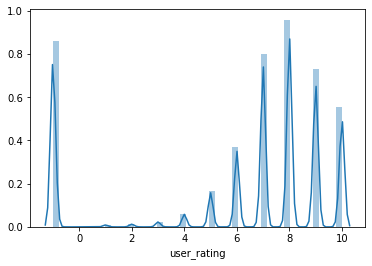

In [6]:
#información basica sobre sobre ratings
sns.distplot(ratings.user_rating)
ratings.describe().compute()

Veamos en más detalle los datos de los usuarios

In [7]:
users=ratings.groupby('user_id').agg({'user_rating':['mean','count','std']})
users.columns=['media','n_puntuaciones','std_puntuaciones']

count    73515.000000
mean         6.647726
std          2.947754
min         -1.000000
25%          6.472973
50%          7.678082
75%          8.377330
max         10.000000
Name: media, dtype: float64

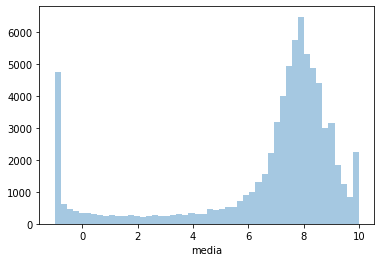

In [8]:
sns.distplot(users.media,kde=False)
users.media.describe().compute()

count    73515.000000
mean       106.287656
std        153.086558
min          1.000000
25%         18.000000
50%         57.000000
75%        136.000000
max      10227.000000
Name: n_puntuaciones, dtype: float64

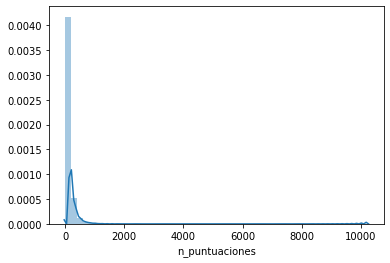

In [9]:
sns.distplot(users.n_puntuaciones)
users.n_puntuaciones.describe().compute()

### 3.2.-  Conclusiones de la Exploración
La media de las puntuaciones de los usuarios es 8.2277 con una aumento en la puntuación 10. A priori se esperaría puntuaciones más centrado en 5, que no sea así puede explicarse suponiendo el sesgo de que esta base esté hecha con personas a las que en general simplemente les gusta el anime. Sabemos que las puntuaciones se realizan en numeros enteros, por lo tanto podemos decir que puntuaciones menores qué 8 significarían algo como "me gustó pero no tanto", mientras que las superiores a 8 son verdaderas medidas de que les gusto, a la vez que la puntuación 8 significaría algo como "me gustó lo mismo que la mayoría".

## 4.- Selección de datos utiles

Nos interesan los usuarios que hayan evaluado almenos 1 anime, y sin considerar las valoraciones -1 ya que no aportan información a los ratings. Además tampoco nos sirven usuarios con muy pocas valoraciones

In [10]:
# Esto significa:
sin_puntuaciones=ratings.groupby(['user_id']).agg({'user_rating':['count','sum']})
print (len(sin_puntuaciones[-sin_puntuaciones['user_rating','sum']==sin_puntuaciones['user_rating','count']]),' usuarios perdidos')

3915  usuarios perdidos


In [11]:
#Nos deshacemos de ambos
ratings=ratings[ratings.user_rating>0]

##### Tampoco nos sirven usuarios con muy pocas valoraciones, no nos gustaría perder más de un 10%

In [12]:
users=ratings.groupby('user_id').agg({'user_rating':['mean','count','std']})
users.columns=['MPRU','n_puntuaciones','std_puntuaciones']

In [13]:
# %  de perdida de usuarios con solo una puntuación:
100*len(users[users.n_puntuaciones<=1])/len(users)

4.668103448275862

In [14]:
# % de perdida de usuarios con 2 o menos puntuaciones:
100*len(users[users.n_puntuaciones<=2])/len(users)

7.67816091954023

In [15]:
# % de perdida de usuarios con 3 o menos puntuaciones:
100*len(users[users.n_puntuaciones<=3])/len(users)

10.225574712643677

##### Un 10.22% nos parece aceptable, por lo que usaremos usuarios con 4 o más puntuaciones.

In [16]:
#usuarios con 4 o más puntuaciones
users=users[users.n_puntuaciones>3]

In [17]:
#Juntamos los datasets para tener la informacipon completa
data=dd.merge(ratings,users,on='user_id',how='inner')

In [18]:
df=dd.merge(data[['user_id','anime_id','user_rating']],anime[['anime_id','name']],on='anime_id',how='left',indicator=True)

In [19]:
df.head()

,user_id,anime_id,user_rating,name,_merge
0,1,8074,10,Highschool of the Dead,both
1,1,11617,10,High School DxD,both
2,1,11757,10,Sword Art Online,both
3,1,15451,10,High School DxD New,both
4,3,20,8,Naruto,both


###### Es posible que algunos datos no nos hayam cruzado, revisemos.

In [20]:
#Revisemos Cuantos no nos cruzaron.
len(data)-len(df[df._merge=='both'])

2

In [21]:
#Esto significa que hay animes id sin nombre correspondiente.
df.anime_id[df['_merge']=='left_only'].compute().unique()

array([30913], dtype=int64)

El anime_id 30913 no tiene un nombre correspondiente, y ha sido puntuado en dos ocasiones.

In [22]:
#dejamos fuera aquellas filas cuyo anime_id no se corresponde entre los dos sets.
df=df[df._merge=='both']

In [23]:
#Armamos un dataset con los tres atributos principales, posteriormente le pondremos nombres a los animes.
df_triple=df[['user_id','anime_id','user_rating']]

In [24]:
len(df_triple)

6324481

In [25]:
reader = Reader(rating_scale=(1.0, 10.0))
data = Dataset.load_from_df(df_triple[['user_id', 'anime_id', 'user_rating']], reader)

## 5.- Escogiendo el Mejor Algoritmo
Probaremos 3 algoritmos que por lo general dan buenos resultados, todos disponibles en la libreria "Surprise".

### BaselineOnly
Este algoritmo basico predice de la siguiente forma:

$$b_{ui} = \mu + b_{u} + b_{i}$$

donde $b_{ui}$ es la puntuación desconocida, $\mu$ la puntuación media del anime, $b_{u}$ es la desviación de puntuaciones del usuario, y $b_{i}$ la desviación de este anime con respecto a la media del total de puntuaciones.

Por ejemplo, supongamos que queremos una estimación de la calificación de Fullmetal Alchemist Brotherhood por un usuario X digamos que la calificación promedio de todas los animes $\mu$, es de 8.2  Además, FMA Brotherhood es mejor
que un anime promedio, por lo que digamos que tiene una puntuación 1.5 por encima del promedio ( $b_{i}$ ). Por otro lado, X es un usuario exigente que tiende a calificar 0.3 más bajo que el promedio ( $b_{u}$ ). Por lo tanto, la estimación de Baseline sería:
$$ 8.2-0.3+1.5=9.4$$

http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf

https://surprise.readthedocs.io/en/stable/basic_algorithms.html

In [26]:
#El performance del algoritmo estara dado por una validación cruzada de 5 iteraciones.
#El conjunto de testeo es una valoración por usuario en el dataset.
results = cross_validate(BaselineOnly(), data, measures=['RMSE'], cv=5, verbose=False)
basel = pd.DataFrame.from_dict(results).mean(axis=0)
basel = basel.append(pd.Series([str(BaselineOnly()).split(' ')[0].split('.')[-1]], index=['BaselineOnly()']))

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [27]:
basel

test_rmse              1.20526
fit_time               21.7878
test_time              10.1659
BaselineOnly()    BaselineOnly
dtype: object

### Co-Clustering

Tanto a los usuarios como a los elementos se les asignan clusters $C_u$ y $C_i$  respectivamente, y algunos co-clusters $C_{ui}$.

La predicción se hace de la siguiente forma:
$$\hat{r}_{ui} = \overline{C_{ui}} + (\mu_u - \overline{C_u}) + (\mu_i- \overline{C_i})$$
donde $\overline{C_{ui}}$ es la calificación promedio de los co-clusters. $\overline{C_u}$ es La calificación promedio de los clusters de usuarios está denotada  y  $\overline{C_u}$ es la calificación del cluster de elementos (items). $\mu_u$ es la media de la puntuación del usuario u, y $\mu_i$ es la media de puntuaciones dado al item i.

https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.113.6458&rep=rep1&type=pdf

https://surprise.readthedocs.io/en/stable/notation_standards.html#george-2005

In [28]:
#El performance del algoritmo estara dado por una validación cruzada de 5 iteraciones.
#El conjunto de testeo es una valoración por usuario en el dataset.
results = cross_validate(CoClustering(), data, measures=['RMSE'], cv=5, verbose=False)
coclus = pd.DataFrame.from_dict(results).mean(axis=0)
coclus = coclus.append(pd.Series([str(CoClustering()).split(' ')[0].split('.')[-1]], index=['CoClustering()']))

In [29]:
coclus

test_rmse               1.2096
fit_time               132.466
test_time              11.8473
CoClustering()    CoClustering
dtype: object

### SlopeOne
Sus predicciones se definen como:
$$ \hat{r}_{ui} = \mu_u + \frac{1}{|R_i(u)|}\sum\limits_{j \in R_i(u)} \text{dev}(i, j)$$
    donde$R_i(u)$ es el conjunto de elementos relevantes, es decir, el conjunto de elementos j valorados por por el usuario u que también tienen al menos un usuario común con i. Además $\text{dev}(i, j)$ se define como la diferencia promedio entre las calificaciones de i y las de j.
 
  "Los algoritmos de Slope One son fáciles de implementar, eficientes para consultar, razonablemente precisos y admiten consultas en línea y actualizaciones dinámicas, lo que los convierte en buenos candidatos para sistemas del mundo real. El esquema básico de pendiente uno se sugiere como un nuevo esquema de referencia para el filtrado colaborativo. Al tener en cuenta los elementos que a un usuario le gustaron por separado de los elementos que no le gustaron, logramos resultados competitivos..."
    
https://arxiv.org/abs/cs/0702144

https://surprise.readthedocs.io/en/stable/slope_one.html#surprise.prediction_algorithms.slope_one.SlopeOne

In [30]:
#El performance del algoritmo estara dado por una validación cruzada de 5 iteraciones.
#El conjunto de testeo es una valoración por usuario en el dataset.
results = cross_validate(SlopeOne(), data, measures=['RMSE'], cv=5, verbose=False)
slope = pd.DataFrame.from_dict(results).mean(axis=0)
slope = slope.append(pd.Series([str(SlopeOne()).split(' ')[0].split('.')[-1]], index=['SlopeOne()']))
winsound.Beep(freq, duration)

In [31]:
slope

test_rmse      1.19573
fit_time       72.4966
test_time      215.465
SlopeOne()    SlopeOne
dtype: object

###### El algoritmo con mejor desempeño en terminos de error cuadratico medio del conjunto de testeo es SlopeOne, veamos como se comporta con un set de testeo del 20%.

In [32]:
trainset, testset = train_test_split(data, test_size=0.20)
slopeone=SlopeOne()
predict_test = slopeone.fit(trainset).test(testset)
accuracy.rmse(predict_test)

winsound.Beep(freq, duration)

RMSE: 1.1959


###### Hagamos un top por usuario con los resultados

In [33]:
def top(user,predict_test=predict_test,anime=anime):
    anime=anime[['anime_id','name']]
    predichos=dd.from_pandas(pd.DataFrame.from_records(predict_test), npartitions=6)
    predichos=predichos[[0,1,2,3]]
    predichos.columns=['user_id','anime_id','p_real','p_predicha']
    predichos=predichos[predichos.user_id==user]
    predichos.p_predicha=predichos.p_predicha.round(decimals=0)
    predichos=predichos.compute()
    #Ya lo redujimos lo suficiente como para usar pandas con normalidad.
    predichos=pd.DataFrame(predichos.sort_values(by='p_predicha',ascending=False).head(3))
    return(pd.merge(predichos,anime.compute(),on='anime_id',how='inner'))

In [34]:
predichos=dd.from_pandas(pd.DataFrame.from_records(predict_test), npartitions=6)
predichos=predichos[[0,1,2,3]]
predichos.columns=['user_id','anime_id','p_real','p_predicha']

##### Juguemos un poco ahora
p_real - Es la puntuación que realmente dieron, por supuesto el algoritmo no tomo en cuenta estas puntuaciones para su predicción.

p_predicha - Es la puntuación predicha por el algoritmo.

In [35]:
top(33888)

,user_id,anime_id,p_real,p_predicha,name
0,33888,22535,9.0,9.0,Kiseijuu: Sei no Kakuritsu
1,33888,2904,8.0,9.0,Code Geass: Hangyaku no Lelouch R2
2,33888,30240,7.0,8.0,Prison School


In [36]:
top(28859)

,user_id,anime_id,p_real,p_predicha,name
0,28859,22297,7.0,7.0,Fate/stay night: Unlimited Blade Works
1,28859,19,7.0,7.0,Monster
2,28859,6746,9.0,7.0,Durarara!!


In [37]:
top(5255)

,user_id,anime_id,p_real,p_predicha,name
0,5255,28977,10.0,10.0,Gintama°
1,5255,16498,10.0,9.0,Shingeki no Kyojin
2,5255,269,10.0,9.0,Bleach


In [38]:
top(65451)

,user_id,anime_id,p_real,p_predicha,name
0,65451,30276,9.0,8.0,One Punch Man
1,65451,9989,6.0,8.0,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...
2,65451,11111,8.0,7.0,Another
